In [216]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import os
from dotenv import load_dotenv
import pyfredapi as pf
import requests
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import warnings

import xgboost as xgb

from itertools import combinations, chain

# Suppress specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [173]:
load_dotenv()
# get my FRED_API_KEY from my local environment
api_key = os.environ['FRED_API_KEY']

In [174]:
start = '1990-01-01'

In [113]:
"""
Business confidence index (BCI) - https://data.oecd.org/leadind/business-confidence-index-bci.htm - 1974
Consumer confidence index (CCI) - https://data.oecd.org/leadind/consumer-confidence-index-cci.htm#indicator-chart - 1974
Composite leading indicator (CLI) - https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart - 1974
"""

'\nBusiness confidence index (BCI) - https://data.oecd.org/leadind/business-confidence-index-bci.htm - 1974\nConsumer confidence index (CCI) - https://data.oecd.org/leadind/consumer-confidence-index-cci.htm#indicator-chart - 1974\nComposite leading indicator (CLI) - https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart - 1974\n'

In [147]:
index_csvs = ['INDEX_DATA/BCI.csv', 'INDEX_DATA/CCI.csv', 'INDEX_DATA/CLI.csv']

index_dfs = [pd.read_csv(index_csv) for index_csv in index_csvs]
cleaned_dfs = []
# stack the dataframes
for df in index_dfs:
    indicator = df['INDICATOR'].iloc[0]
    df = df.loc[df['LOCATION'] == 'USA', ['TIME', 'Value']].rename(columns={'Value': 'value_' + indicator, 'TIME': 'date'})
    # set the index to the time column as a datetime object
    df.set_index(pd.to_datetime(df['date']), inplace=True)
    # drop the old time column
    df.drop(columns=['date'], inplace=True)

    # drop all rows with index before string 'start'
    df = df.loc[df.index >= start]

    cleaned_dfs.append(df)

# merge the cleaned_dfs
index_df = pd.concat(cleaned_dfs, axis=1)

In [3]:
data_sources = """
(FEDFUNDS)
Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
Sticky Price Consumer Price Index less Food and Energy (CORESTICKM159SFRBATL)
Sticky Price Consumer Price Index less Food, Energy, and Shelter (CRESTKCPIXSLTRM159SFRBATL)
Producer Price Index by Commodity: All Commodities (PPIACO)
Personal Consumption Expenditures (PCE) 
Total Nonfarm Private Payroll Employment (ADPWNUSNERSA)
Quarterly Financial Report: U.S. Corporations: All Information: Total Cash on Hand and in U.S. Banks  (QFRTCASHINFUSNO) - only to 2009 
Unemployment Rate (UNRATE)
Noncyclical Rate of Unemployment (NROU)
Unemployment Rate - Women (LNS14000002)
Job Openings: Total Nonfarm (JTSJOL) - begins 2000
Layoffs and Discharges: Total Nonfarm (JTSLDL) - since 2000 Gross Domestic Product (GDP)
Real Gross Domestic Product (GDPC1)
Real gross domestic product per capita (A939RX0Q048SBEA)
Gross Domestic Product: Implicit Price Deflator (A191RI1Q225SBEA)
National Accounts: National Accounts Deflators: Gross Domestic Product: GDP Deflator for United States (USAGDPDEFQISMEI)
Advance Retail Sales: Retail Trade and Food Services (RSAFS) - 1992 
University of Michigan: Consumer Sentiment (UMCSENT)
New Privately-Owned Housing Units Started: Total Units (HOUST)
New Privately-Owned Housing Units Started: Single-Family Units (HOUST1F)
Total Business Sales (TOTBUSSMSA) -1992

Nonfinancial Corporate Business; Inventories Including IVA, Market Value Levels (BOGZ1LM105020005Q)
Corporate Profits After Tax -without IVA and CCAdj- (CP)
 National income: Corporate profits before tax -without IVA and CCAdj- (A053RC1Q027SBEA)
Money Market Funds; Total Financial Assets, Level (MMMFFAQ027S)
Stock Market Capitalization to GDP for United States (DDDM01USA156NWDB)
Interest Rates: Long-Term Government Bond Yields: 10-Year: Main -Including Benchmark- for United States (IRLTLT01USM156N)
Nominal Broad U.S. Dollar Index (DTWEXBGS) - 2006
Leading Indicators OECD: Leading indicators: CLI: Amplitude adjusted for OECD - Total (OECDLOLITOAASTSAM)
Trade Balance: Goods and Services, Balance of Payments Basis (BOPGSTB) - 1992
M1 (WM1NS)
Velocity of M1 Money Stock (M1V)
M2 (WM2NS)
"""

In [148]:
# Regular expression pattern to match text within parentheses
pattern = r"\((.*?)\)"

# Find all matches and store them in a list
matches = re.findall(pattern, data_sources)

In [149]:
dataframes = {}

In [150]:
start = '1990-01-01'
# end with the current date
end = pd.Timestamp.today().strftime('%Y-%m-%d')

extra_parameters = {
    "observation_start": start,
    "observation_end": end,
}
for match in matches:
    series_id = match
    try:
        df = pf.get_series(series_id=series_id, **extra_parameters)[['date', 'value']]
        # add the match to the end of the value column name
        df.rename(columns={'value': f'value_{match}'}, inplace=True)
        # turn the date column into a datetime object
        df['date'] = pd.to_datetime(df['date'])

        # set the date column as the index
        df.set_index('date', inplace=True)
        dataframes[series_id] = df

    except:
        print(f"Failed to get {series_id}")
# gdp_df = pf.get_series(series_id="FEDFUNDS", **extra_parameters)
# display(gdp_df)

In [151]:
def align_dataframes(dataframes):
    aligned_dfs = []
    start_date = '1990-01-01'

    for df in dataframes:
        # Ensure the index is a DateTimeIndex
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)

        # Resample to monthly frequency
        # Use 'mean' for downsampling and 'ffill' for upsampling
        resampled_df = df.resample('M').mean().ffill()

        # Align start date to January 1990, filling missing values with NaN
        aligned_df = resampled_df.reindex(pd.date_range(start_date, resampled_df.index.max(), freq='M'), fill_value=np.nan)
        
        aligned_dfs.append(aligned_df)

    return aligned_dfs

In [205]:
dataframes_list = list(dataframes.values()) + [index_df]

display(dataframes_list[-1])

# Align all DataFrames to the same frequency and start date
aligned_dataframes = align_dataframes(dataframes_list)

# Concatenate all DataFrames along the column axis
combined_df = pd.concat(aligned_dataframes, axis=1)

display(combined_df)

,value_BCI,value_CCI,value_CLI
date,,,
1990-01-01,98.82152,100.64830,99.79324
1990-02-01,99.03415,100.63020,99.82359
1990-03-01,99.20221,100.69920,99.82265
1990-04-01,99.25509,100.75180,99.74673
1990-05-01,99.17876,100.62180,99.57410
...,...,...,...
2023-06-01,98.50663,97.54726,99.11828
2023-07-01,98.58130,97.90887,99.24326
2023-08-01,98.72079,97.98888,99.34666


,value_FEDFUNDS,value_CPIAUCSL,value_CORESTICKM159SFRBATL,value_CRESTKCPIXSLTRM159SFRBATL,value_PPIACO,value_PCE,value_ADPWNUSNERSA,value_QFRTCASHINFUSNO,value_UNRATE,value_NROU,...,value_IRLTLT01USM156N,value_DTWEXBGS,value_OECDLOLITOAASTSAM,value_BOPGSTB,value_WM1NS,value_M1V,value_WM2NS,value_BCI,value_CCI,value_CLI
1990-01-31,8.23,127.500,4.920589,4.822856,114.900,3730.7,NaN,NaN,5.4,5.732765,...,8.21,NaN,100.686551,NaN,805.860,7.356,3173.160,98.82152,100.64830,99.79324
1990-02-28,8.24,128.000,4.935526,5.031079,114.400,3728.2,NaN,NaN,5.3,5.732765,...,8.47,NaN,100.691920,NaN,786.300,7.356,3169.175,99.03415,100.63020,99.82359
1990-03-31,8.28,128.600,5.208701,5.303906,114.200,3754.9,NaN,NaN,5.2,5.732765,...,8.59,NaN,100.675582,NaN,793.500,7.356,3189.875,99.20221,100.69920,99.82265
1990-04-30,8.26,128.900,5.294134,5.351800,114.100,3770.0,NaN,NaN,5.4,5.713231,...,8.79,NaN,100.619091,NaN,813.200,7.391,3216.700,99.25509,100.75180,99.74673
1990-05-31,8.18,129.100,5.183754,5.319868,114.600,3775.8,NaN,NaN,5.4,5.713231,...,8.76,NaN,100.510613,NaN,795.150,7.391,3186.150,99.17876,100.62180,99.57410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,5.12,304.348,5.456089,3.265160,253.805,18621.3,128846600.0,NaN,3.5,4.421397,...,3.90,118.584800,NaN,-64718.0,18345.020,1.511,20749.380,98.58130,97.90887,99.24326
2023-08-31,5.33,306.269,5.217343,3.094960,257.675,18689.9,128955000.0,NaN,3.8,4.421397,...,4.17,120.378709,NaN,-58657.0,18232.575,NaN,20718.350,98.72079,97.98888,99.34666
2023-09-30,5.33,307.481,5.008782,2.919115,258.889,18823.4,129091200.0,NaN,3.8,4.421397,...,4.38,122.125230,NaN,-61542.0,18153.050,NaN,20703.425,98.79745,97.82825,99.42249
2023-10-31,5.33,307.619,4.931956,2.979587,255.463,18864.7,129222250.0,NaN,3.9,4.418317,...,4.80,123.904114,NaN,NaN,18047.300,NaN,20674.720,98.71177,97.52642,99.47179


In [124]:
# # Assuming 'combined_df' is your combined DataFrame
# corr_matrix = combined_df.corr()

# # Display the correlation matrix
# print(corr_matrix)

# # Plotting a heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix Heatmap')
# plt.show()

In [206]:
features = combined_df.drop('value_FEDFUNDS', axis=1)
label = combined_df['value_FEDFUNDS']

# Filling missing values with the mean (change this based on your data's context)
features_filled = features.fillna(features.mean())


In [56]:
# # plot the label
# plt.plot(label.index, label)
# plt.title('FEDFUNDS')

In [154]:
split_date = '2015-01-01'
train_features = features[:split_date]
test_features = features[split_date:]
train_label = label[:split_date]

test_label = label[split_date:]

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Apply imputation to the training and testing sets
train_features_imputed = imputer.fit_transform(train_features)
test_features_imputed = imputer.transform(test_features)

# Then, standardize and apply PCA as before
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_features_scaled)
test_pca = pca.transform(test_features_scaled)

# Create Ridge regression model
ridge_model = linear_model.Ridge(alpha=1.0, solver='svd')

# Fit the model using transformed features
ridge_model.fit(train_pca, train_label)

# Make predictions using transformed test features
predicted_rates = ridge_model.predict(test_pca)
predicted_rates = np.clip(predicted_rates, 0, None)

# Calculate MSE
mse = mean_squared_error(test_label, predicted_rates)

# Print the MSE
print("Mean Squared Error:", mse)

Mean Squared Error: 4.346884980337394


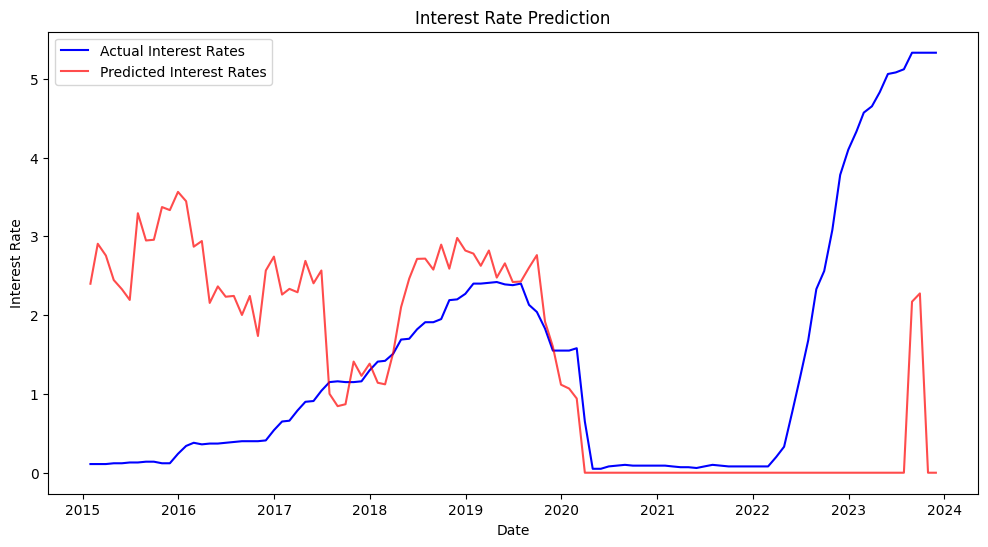

In [155]:
# Assuming the index of your test set represents the dates
test_dates = test_label.index

plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_label, label='Actual Interest Rates', color='blue')
plt.plot(test_dates, predicted_rates, label='Predicted Interest Rates', color='red', alpha=0.7)
plt.title('Interest Rate Prediction')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

Mean Squared Error with XGBoost: 4.135320990259507


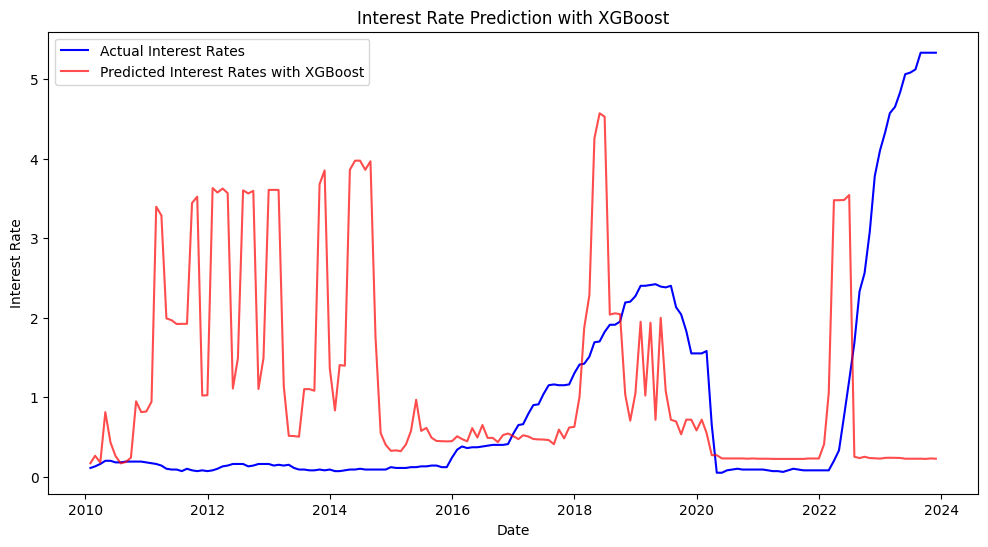

In [157]:
split_date = '2010-01-01'
train_features = features[:split_date]
test_features = features[split_date:]
train_label = label[:split_date]
test_label = label[split_date:]

imputer = SimpleImputer(strategy='mean')
train_features_imputed = imputer.fit_transform(train_features)
test_features_imputed = imputer.transform(test_features)

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_features_scaled)
test_pca = pca.transform(test_features_scaled)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(train_pca, train_label)

xgb_predictions = xgb_model.predict(test_pca)
# xgb_predictions = np.clip(xgb_predictions, 0, None)

mse_xgb = mean_squared_error(test_label, xgb_predictions)
print("Mean Squared Error with XGBoost:", mse_xgb)

plt.figure(figsize=(12, 6))
plt.plot(test_label.index, test_label, label='Actual Interest Rates', color='blue')
plt.plot(test_label.index, xgb_predictions, label='Predicted Interest Rates with XGBoost', color='red', alpha=0.7)
plt.title('Interest Rate Prediction with XGBoost')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

In [203]:
split_date = '2015-01-01'
features = features[['value_CORESTICKM159SFRBATL', 'value_PCE', 'value_CLI', 'value_CPIAUCSL']]
train_features = features[:split_date]
print(train_features.shape)
test_features = features[split_date:]
train_label = label[:split_date]
test_label = label[split_date:]
imputer = SimpleImputer(strategy='mean')
train_features_imputed = imputer.fit_transform(train_features)
test_features_imputed = imputer.transform(test_features)

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_imputed)
test_features_scaled = scaler.transform(test_features_imputed)


xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(train_features_scaled, train_label)

xgb_predictions = xgb_model.predict(test_features_scaled)
# xgb_predictions = np.clip(xgb_predictions, 0, None)

mse_xgb = mean_squared_error(test_label, xgb_predictions)
print("Mean Squared Error with XGBoost:", mse_xgb)


(300, 4)
Mean Squared Error with XGBoost: 2.5154452816199435


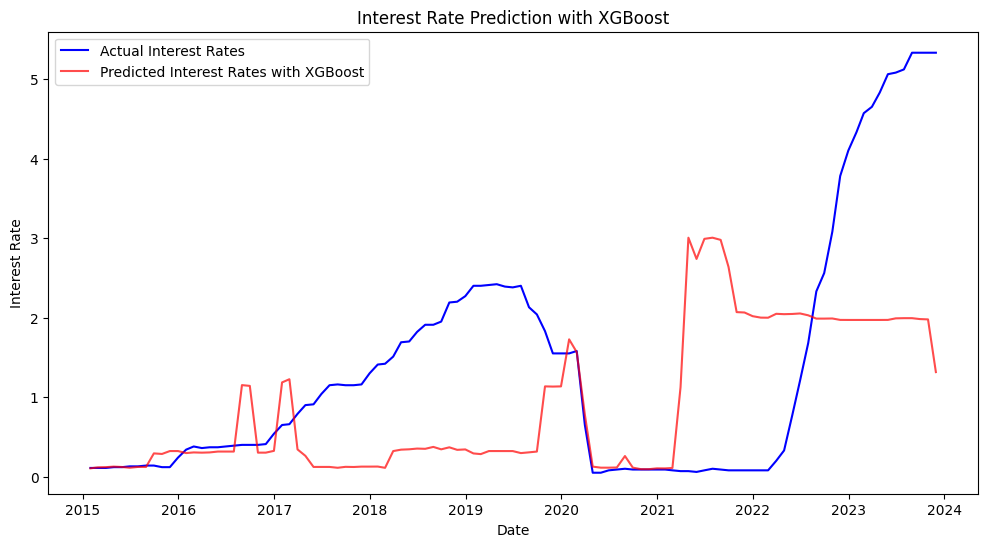

In [202]:
plt.figure(figsize=(12, 6))
plt.plot(test_label.index, test_label, label='Actual Interest Rates', color='blue')
plt.plot(test_label.index, xgb_predictions, label='Predicted Interest Rates with XGBoost', color='red', alpha=0.7)
plt.title('Interest Rate Prediction with XGBoost')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

In [162]:
def is_collinear_combo(combo, collinear_pairs):
    for pair in combinations(combo, 2):
        if frozenset(pair) in collinear_pairs:
            return True
    return False

In [215]:
# Assuming 'features' is your DataFrame
corr_matrix = features.corr().abs()

# Threshold for considering correlation as 'high'
threshold = 0.8

# Grouping collinear features
collinear_groups = []
visited = set()

for col in corr_matrix.columns:
    if col not in visited:
        collinear_set = set([col])
        for index in corr_matrix.index[corr_matrix[col] > threshold]:
            if col != index:
                collinear_set.add(index)
                visited.add(index)
        collinear_groups.append(collinear_set)

# Selecting one representative from each collinear group
representatives = [list(group)[0] for group in collinear_groups]

# Generate all combinations of the representatives
combos = []
for i in range(1, len(representatives) + 1):
    combos += list(combinations(representatives, i))

combos = list(set(combos))

print(len(combos))
label_binary = label.diff().dropna()
split_date = int(len(label_binary) * 0.8)
label_binary = np.where(label_binary > 0, 1, 0)


best_combos = []
best_combo = None
best_acc = 0

for combo in combos:
    combo = list(set(combo))
    features_adjusted = features[list(combo)].iloc[1:]

    train_features = features_adjusted[:split_date]
    test_features = features_adjusted[split_date:]
    train_label = label_binary[:split_date]
    test_label = label_binary[split_date:]

    # Model creation and fitting
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_classifier.fit(train_features, train_label)

    # Predictions and evaluation
    xgb_predictions = xgb_classifier.predict(test_features)
    acc = accuracy_score(test_label, xgb_predictions)
    
    if acc < best_acc:
        best_acc = acc
        best_combo = combo

    if acc > 0.70:
        print("Combo:", combo, "Accuracy:", acc)
        best_combos.append(combo)

print("Best combo:", best_combo)
print("Best MSE:", best_acc)

features_adjusted = features[list(best_combo)].iloc[1:]

train_features = features_adjusted[:split_date]
test_features = features_adjusted[split_date:]
train_label = label_binary[:split_date]
test_label = label_binary[split_date:]

# Model creation and fitting
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_classifier.fit(train_features, train_label)

# Predictions and evaluation
xgb_predictions = xgb_classifier.predict(test_features)
mse = mean_squared_error(test_label, xgb_predictions)

print("Mean Squared Error:", mse)

print(accuracy_score(test_label, xgb_predictions))
print(classification_report(test_label, xgb_predictions))

4087


KeyboardInterrupt: 

In [222]:
# Assuming 'features' is your DataFrame
corr_matrix = features.corr().abs()

# Threshold for considering correlation as 'high'
threshold = 0.6

# Grouping collinear features
collinear_groups = []
already_grouped = set()

for col in corr_matrix.columns:
    if col not in already_grouped:
        collinear_set = {col}
        for index in corr_matrix.index[corr_matrix[col] > threshold]:
            if col != index and index not in already_grouped:
                collinear_set.add(index)
                already_grouped.add(index)
        if len(collinear_set) > 1:
            collinear_groups.append(collinear_set)

# Select one representative from each collinear group
representatives = [list(group)[0] for group in collinear_groups]

# Add non-collinear features to the representatives
non_collinear_features = [col for col in features.columns if col not in already_grouped]
representatives.extend(non_collinear_features)

# Create a set of all unique representatives and non-collinear features
unique_features = set(representatives)

# Generate combinations of varying sizes from this set
combos = list(chain.from_iterable(combinations(unique_features, r) for r in range(1, len(unique_features)+1)))

print(f"Number of combinations: {len(combos)}")

# You can now proceed with the rest of your analysis using these combinations


label_binary = label.diff().dropna()
split_date = int(len(label_binary) * 0.8)
label_binary = np.where(label_binary > 0, 1, 0)


best_combos = []
best_combo = None
best_acc = 0

for combo in combos:
    combo = list(set(combo))
    features_adjusted = features[list(combo)].iloc[1:]

    train_features = features_adjusted[:split_date]
    test_features = features_adjusted[split_date:]
    train_label = label_binary[:split_date]
    test_label = label_binary[split_date:]

    # Model creation and fitting
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_classifier.fit(train_features, train_label)

    # Predictions and evaluation
    xgb_predictions = xgb_classifier.predict(test_features)
    acc = accuracy_score(test_label, xgb_predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_combo = combo

    if acc > 0.70:
        print("Combo:", combo, "Accuracy:", acc)
        best_combos.append(combo)

print("Best combo:", best_combo)
print("Best MSE:", best_acc)

features_adjusted = features[list(best_combo)].iloc[1:]

train_features = features_adjusted[:split_date]
test_features = features_adjusted[split_date:]
train_label = label_binary[:split_date]
test_label = label_binary[split_date:]

# Model creation and fitting
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_classifier.fit(train_features, train_label)

# Predictions and evaluation
xgb_predictions = xgb_classifier.predict(test_features)
mse = mean_squared_error(test_label, xgb_predictions)

print("Mean Squared Error:", mse)

print(accuracy_score(test_label, xgb_predictions))
print(classification_report(test_label, xgb_predictions))

Number of combinations: 4095
Combo: ['value_CORESTICKM159SFRBATL', 'value_PCE', 'value_CLI'] Accuracy: 0.7439024390243902
Combo: ['value_BCI', 'value_UNRATE', 'value_PCE'] Accuracy: 0.7073170731707317
Combo: ['value_BCI', 'value_CPIAUCSL', 'value_UMCSENT'] Accuracy: 0.7073170731707317
Combo: ['value_BCI', 'value_CORESTICKM159SFRBATL', 'value_UNRATE', 'value_A191RI1Q225SBEA'] Accuracy: 0.7195121951219512
Combo: ['value_CORESTICKM159SFRBATL', 'value_PCE', 'value_CLI', 'value_M1V'] Accuracy: 0.7195121951219512
Combo: ['value_CORESTICKM159SFRBATL', 'value_HOUST1F', 'value_PCE', 'value_CLI'] Accuracy: 0.7073170731707317
Combo: ['value_CORESTICKM159SFRBATL', 'value_PCE', 'value_CLI', 'value_CPIAUCSL'] Accuracy: 0.7682926829268293
Combo: ['value_UMCSENT', 'value_CORESTICKM159SFRBATL', 'value_M1V', 'value_CPIAUCSL'] Accuracy: 0.7195121951219512
Combo: ['value_UNRATE', 'value_PCE', 'value_CLI', 'value_M1V'] Accuracy: 0.7073170731707317
Combo: ['value_CORESTICKM159SFRBATL', 'value_M1V', 'value_B

In [236]:
# Assuming 'features' is your DataFrame
corr_matrix = features.corr().abs()

# Threshold for considering correlation as 'high'
threshold = 0.1

# Grouping collinear features
collinear_groups = []
already_grouped = set()

for col in corr_matrix.columns:
    if col not in already_grouped:
        collinear_set = {col}
        for index in corr_matrix.index[corr_matrix[col] > threshold]:
            if col != index and index not in already_grouped:
                collinear_set.add(index)
                already_grouped.add(index)
        if len(collinear_set) > 1:
            collinear_groups.append(collinear_set)

# Select one representative from each collinear group
representatives = [list(group)[0] for group in collinear_groups]

# Add non-collinear features to the representatives
non_collinear_features = [col for col in features.columns if col not in already_grouped]
representatives.extend(non_collinear_features)

# Create a set of all unique representatives and non-collinear features
unique_features = set(representatives)

# Generate combinations of varying sizes from this set
combos = list(chain.from_iterable(combinations(unique_features, r) for r in range(1, len(unique_features)+1)))

print(f"Number of combinations: {len(combos)}")

# print(combos)


for combo in combos:
    print(combo)


    features_adjusted = features[list(combo)].iloc[1:]

    train_features = features_adjusted[:split_date]
    test_features = features_adjusted[split_date:]
    train_label = label_binary[:split_date]
    test_label = label_binary[split_date:]
    features_adjusted = features[list(best_combo)].iloc[1:]


    # Model creation and fitting
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_classifier.fit(train_features, train_label)

    # Predictions and evaluation
    xgb_predictions = xgb_classifier.predict(test_features)
    mse = mean_squared_error(test_label, xgb_predictions)

    print("Mean Squared Error:", mse)

    print(accuracy_score(test_label, xgb_predictions))
    print(classification_report(test_label, xgb_predictions))

    # xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],  # Fraction of samples to be used for fitting each tree
        'colsample_bytree': [0.8, 1.0]  # Fraction of features to be used for each tree
    }

    # # Grid Search with Cross-Validation
    # grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
    # grid_search.fit(train_features, train_label)

    # # Best parameters
    # print("Best parameters found: ", grid_search.best_params_)

    # # Evaluate on test set with the best model
    # best_model = grid_search.best_estimator_
    # xgb_predictions = best_model.predict(test_features)

    # mse = mean_squared_error(test_label, xgb_predictions)
    # accuracy = accuracy_score(test_label, xgb_predictions)

    # print("Mean Squared Error:", mse)
    # print("Accuracy:", accuracy)
    # print(classification_report(test_label, xgb_predictions))

Number of combinations: 7
('value_CORESTICKM159SFRBATL',)
Mean Squared Error: 0.4634146341463415
0.5365853658536586
              precision    recall  f1-score   support

           0       0.46      0.62      0.52        34
           1       0.64      0.48      0.55        48

    accuracy                           0.54        82
   macro avg       0.55      0.55      0.54        82
weighted avg       0.56      0.54      0.54        82

('value_JTSLDL',)
Mean Squared Error: 0.5975609756097561
0.4024390243902439
              precision    recall  f1-score   support

           0       0.38      0.74      0.51        34
           1       0.47      0.17      0.25        48

    accuracy                           0.40        82
   macro avg       0.43      0.45      0.38        82
weighted avg       0.43      0.40      0.35        82

('value_CPIAUCSL',)
Mean Squared Error: 0.4146341463414634
0.5853658536585366
              precision    recall  f1-score   support

           0       0.

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean Squared Error: 0.573170731707317
0.4268292682926829
              precision    recall  f1-score   support

           0       0.28      0.24      0.25        34
           1       0.51      0.56      0.53        48

    accuracy                           0.43        82
   macro avg       0.39      0.40      0.39        82
weighted avg       0.41      0.43      0.42        82

('value_JTSLDL', 'value_CPIAUCSL')
Mean Squared Error: 0.5121951219512195
0.4878048780487805
              precision    recall  f1-score   support

           0       0.39      0.44      0.42        34
           1       0.57      0.52      0.54        48

    accuracy                           0.49        82
   macro avg       0.48      0.48      0.48        82
weighted avg       0.50      0.49      0.49        82

('value_CORESTICKM159SFRBATL', 'value_JTSLDL', 'value_CPIAUCSL')
Mean Squared Error: 0.524390243902439
0.47560975609756095
              precision    recall  f1-score   support

           0      

In [244]:

features_adjusted = features[list(best_combo)].iloc[1:]

train_features = features_adjusted[:split_date]
test_features = features_adjusted[split_date:]
train_label = label_binary[:split_date]
test_label = label_binary[split_date:]
features_adjusted = features[list(best_combo)].iloc[1:]


# Model creation and fitting
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_classifier.fit(train_features, train_label)

# Predictions and evaluation
xgb_predictions = xgb_classifier.predict(test_features)
mse = mean_squared_error(test_label, xgb_predictions)

print("Mean Squared Error:", mse)

print(accuracy_score(test_label, xgb_predictions))
print(classification_report(test_label, xgb_predictions))
# Model creation
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

# Assuming 'features', 'label_binary', 'split_date' are predefined

# Manually split the data based on time

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Maximum tree depth
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required for a split
    'subsample': [0.7, 0.8, 0.9],  # Subsample ratio of the training instance
    'colsample_bytree': [0.7, 0.8, 0.9],  # Subsample ratio of columns when constructing each tree
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term
    'reg_lambda': [1, 1.5, 2]  # L2 regularization term
}


# Manual Grid Search
best_params = None
best_accuracy = 0

i = 0
for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            for min_child_weight in param_grid['min_child_weight']:
                for gamma in param_grid['gamma']:
                    for subsample in param_grid['subsample']:
                        for colsample_bytree in param_grid['colsample_bytree']:
                            for reg_alpha in param_grid['reg_alpha']:
                                for reg_lambda in param_grid['reg_lambda']:
                                    # Create and fit the model
                                    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators,
                                                                          learning_rate=learning_rate, max_depth=max_depth,
                                                                          min_child_weight=min_child_weight, gamma=gamma,
                                                                          subsample=subsample, colsample_bytree=colsample_bytree,
                                                                          reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=42)
                                    xgb_classifier.fit(train_features, train_label)

                                    # Evaluate on the validation set
                                    val_predictions = xgb_classifier.predict(test_features)
                                    accuracy = accuracy_score(test_label, val_predictions)

                                    # Update best params
                                    if accuracy > best_accuracy:
                                        best_accuracy = accuracy
                                        best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate,
                                                         'max_depth': max_depth, 'min_child_weight': min_child_weight,
                                                         'gamma': gamma, 'subsample': subsample,
                                                         'colsample_bytree': colsample_bytree,
                                                         'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda}
                                    print(i)
                                    i += 1
                                        
print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

# Train the best model
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', **best_params, random_state=42)
xgb_classifier.fit(train_features, train_label)

# Evaluate on the test set
test_predictions = xgb_classifier.predict(test_features)
mse = mean_squared_error(test_label, test_predictions)
accuracy = accuracy_score(test_label, test_predictions)

print("Mean Squared Error on Test Data:", mse)
print("Accuracy on Test Data:", accuracy)
print(classification_report(test_label, test_predictions))

                                    
                                        # Other parameters...

                                        # # Create and fit the model
                                        # xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators,
                                        #                                    learning_rate=learning_rate, max_depth=max_depth,
                                        #                                    min_child_weight=min_child_weight, gamma=gamma,
                                        #                                    subsample=subsample, colsample_bytree=colsample_bytree,
                                        #                                    colsample_bylevel=colsample_bylevel, reg_alpha=reg_alpha,
                                        #                                    reg_lambda=reg_lambda, random_state=42)
                                        # xgb_classifier.fit(train_features, train_label)

                                        # # Evaluate on the validation set
                                        # val_predictions = xgb_classifier.predict(test_features)
                                        # accuracy = accuracy_score(test_label, val_predictions)

                                        # # Update best params
                                        # if accuracy > best_accuracy:
                                        #     best_accuracy = accuracy
                                        #     best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate,
                                        #                    'max_depth': max_depth, 'min_child_weight': min_child_weight,
                                        #                    'gamma': gamma, 'subsample': subsample,
                                        #                    'colsample_bytree': colsample_bytree,
                                        #                    'colsample_bylevel': colsample_bylevel,
                                        #                    'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda}
            # Other parameters...
            
#             # Create and fit the model
#             xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, 
#                                                learning_rate=learning_rate, max_depth=max_depth, random_state=42)
#             xgb_classifier.fit(train_features, train_label)
            
#             # Evaluate on the validation set
#             val_predictions = xgb_classifier.predict(test_features)
#             accuracy = accuracy_score(test_label, val_predictions)
            
#             # Update best params
#             if accuracy > best_accuracy:
#                 best_accuracy = accuracy
#                 best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}

# # Train the best model
# xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', **best_params, random_state=42)
# xgb_classifier.fit(train_features, train_label)

# # Evaluate on the test set
# test_predictions = xgb_classifier.predict(test_features)
# mse = mean_squared_error(test_label, test_predictions)
# accuracy = accuracy_score(test_label, test_predictions)

# print("Best parameters:", best_params)
# print("Mean Squared Error on Test Data:", mse)
# print("Accuracy on Test Data:", accuracy)
# print(classification_report(test_label, test_predictions))


Mean Squared Error: 0.23170731707317074
0.7682926829268293
              precision    recall  f1-score   support

           0       0.78      0.62      0.69        34
           1       0.76      0.88      0.82        48

    accuracy                           0.77        82
   macro avg       0.77      0.75      0.75        82
weighted avg       0.77      0.77      0.76        82

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180


In [247]:

features_adjusted = features[list(best_combo)].iloc[1:]

train_features = features_adjusted[:split_date]
test_features = features_adjusted[split_date:]
train_label = label_binary[:split_date]
test_label = label_binary[split_date:]
features_adjusted = features[list(best_combo)].iloc[1:]
# train using the best parameters
print(best_params)
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', **best_params, random_state=42)
xgb_classifier.fit(train_features, train_label)

# Predictions and evaluation
xgb_predictions = xgb_classifier.predict(test_features)
mse = mean_squared_error(test_label, xgb_predictions)

print("Mean Squared Error:", mse)

print(accuracy_score(test_label, xgb_predictions))
print(classification_report(test_label, xgb_predictions))


{'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 2}
Mean Squared Error: 0.18292682926829268
0.8170731707317073
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        34
           1       0.85      0.83      0.84        48

    accuracy                           0.82        82
   macro avg       0.81      0.81      0.81        82
weighted avg       0.82      0.82      0.82        82



In [200]:
# # Assuming 'features' is your DataFrame
# corr_matrix = features.corr().abs()

# # Threshold for considering correlation as 'high'
# threshold = 0.8

# # Grouping collinear features
# collinear_groups = []
# already_grouped = set()

# for col in corr_matrix.columns:
#     if col not in already_grouped:
#         collinear_set = {col}
#         for index in corr_matrix.index[corr_matrix[col] > threshold]:
#             if col != index and index not in already_grouped:
#                 collinear_set.add(index)
#                 already_grouped.add(index)
#         if len(collinear_set) > 1:
#             collinear_groups.append(collinear_set)

#             # Assuming 'label' is your target variable
# label_corr = features.corrwith(label).abs()

# # Filter out non-collinear features that are highly correlated with the label
# non_collinear_features = [col for col in features.columns if col not in already_grouped and label_corr[col] <= threshold]

# # Generate all possible combinations of non-collinear features
# non_collinear_combos = []
# for i in range(1, len(non_collinear_features) + 1):
#     non_collinear_combos += list(combinations(non_collinear_features, i))

# # Generate all combinations where each feature in a collinear group can be a representative
# all_possible_collinear_combos = list(product(*collinear_groups))

# # Combine collinear and non-collinear combinations
# final_combos = []
# for collinear_combo in all_possible_collinear_combos:
#     for non_collinear_combo in non_collinear_combos:
#         final_combos.append(collinear_combo + non_collinear_combo)

# # remove duplicates from final_combos
# final_combos = list(set(final_combos))
# print(len(final_combos))



# label_binary = label.diff().dropna()
# split_date = int(len(label_binary) * 0.8)
# label_binary = np.where(label_binary > 0, 1, 0)

# best_combo = None
# best_MSE = np.inf

# for i, combo in enumerate(final_combos):
#     # remove duplicate elements in combo
#     combo = list(set(combo))
#     print(i)
#     features_adjusted = features[list(combo)].iloc[1:]

#     train_features = features_adjusted[:split_date]
#     test_features = features_adjusted[split_date:]
#     train_label = label_binary[:split_date]
#     test_label = label_binary[split_date:]

#     # Model creation and fitting
#     xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
#     xgb_classifier.fit(train_features, train_label)

#     # Predictions and evaluation
#     xgb_predictions = xgb_classifier.predict(test_features)
#     mse = mean_squared_error(test_label, xgb_predictions)
    
#     if mse < best_MSE:
#         best_MSE = mse
#         best_combo = combo

# print(best_combo)


In [57]:
# Create a binary label for increase (1) or decrease (0) in interest rates
label_binary = label.diff().dropna()
label_binary = np.where(label_binary > 0, 1, 0)

# Shift the binary label forward by one period
for i in range(1, 13):
    label_shifted = np.roll(label_binary, -i)

    features_aligned = features.iloc[1:-1]
    label_aligned = label_shifted[:-1]


    split_index = int(len(label_aligned) * 0.8)

    train_features = features_aligned[:split_index]
    test_features = features_aligned[split_index:]
    train_label = label_aligned[:split_index]
    test_label = label_aligned[split_index:]


    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1, max_depth=5, random_state=42)
    xgb_classifier.fit(train_features, train_label)

    xgb_predictions = xgb_classifier.predict(test_features)
    accuracy = accuracy_score(test_label, xgb_predictions)

    print("Accuracy:", accuracy)
    # print(classification_report(test_label, xgb_predictions))


Accuracy: 0.5679012345679012
Accuracy: 0.38271604938271603
Accuracy: 0.5555555555555556
Accuracy: 0.5925925925925926
Accuracy: 0.5679012345679012
Accuracy: 0.5432098765432098
Accuracy: 0.5555555555555556
Accuracy: 0.5679012345679012
Accuracy: 0.37037037037037035
Accuracy: 0.4691358024691358
Accuracy: 0.43209876543209874
Accuracy: 0.48148148148148145


In [ ]:
# # get tags
# request_url = f'https://api.stlouisfed.org/fred/tags'

# params = {
#     'api_key': api_key,
#     'file_type': 'json',
#     'limit': 1000,
#     'order_by': 'popularity',
#     # 'offset': 0,
# }
# tags_response = requests.get(request_url, params=params)
# # response_json = tags_response.json()
# # tags_df = pd.DataFrame(response_json['tags'])
# # display(tags_df)
# # print(tags_df['name'].to_list())

In [106]:
# response_json = tags_response.json()
# tags_df = pd.DataFrame(response_json['tags'])
# display(tags_df)

In [107]:
# request_url = f'https://api.stlouisfed.org/fred/releases'

# params = {
#     'api_key': api_key,
#     'file_type': 'json',
#     'limit': 1000,
#     # 'offset': 10,
# }
# response = requests.get(request_url, params=params)
# # # print the 'name' for each Release
# # for release in response.json()['releases']:
# #     print(release['name'])